In [1]:
import numpy as np
import xarray as xr
import pandas as pd

import ecco_v4_py as ecco

import datetime
import matplotlib.dates as mdates

import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/pandas/compat/_optional.py:106: UserWarning: Pandas requires version '1.2.1' or newer of 'bottleneck' (version '1.2.0' currently installed).
  warnings.warn(msg, UserWarning)


### Import ECCO dataset

In [2]:
main = xr.open_zarr('/mnt/efs/data/ecco/zarr/eccov4r3_output/').rename({'face': 'tile'})

### Useful quantities

In [3]:
# Density kg/m^3
rhoconst = 1029

# m^3 to Sverdrup
Sv = 10**-6

### Define the section lines 

In [4]:
pt1,pt2 = ecco.get_section_endpoints('Davis Strait')
maskC, maskW, maskS = ecco.get_section_line_masks(pt1,pt2,main)

### Grid area along section

**$X$**: ds.UVELMASS
`hFacW`, `maskW`
- Tile 2: zonal
- Tile 6: meridional
- Tile 10: meridional

**$Y$**: ds.VVELMASS
`hFacS`, `maskS`
- Tile 2: meridional
- Tile 6: zonal
- Tile 10: zonal

In [5]:
# Cell area along y at u location (m^2)
dyA = main.dyG*main.drF*main.hFacW

# Cell area along x at v location (m^2)
dxA = main.dxG*main.drF*main.hFacS

In [6]:
# Get area for Davis Strait
dyA_DaS = dyA*maskW*-1
dxA_DaS = dxA*maskS*-1

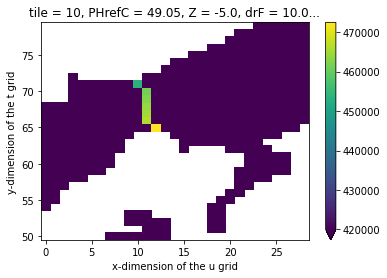

In [7]:
dyA_DaS[10,:,:,0].where(main.hFacW[0,10].values==1)[50:80,:29].plot(vmin=4.2e5)

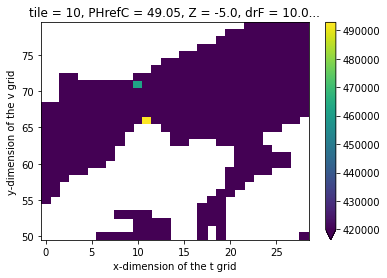

In [8]:
dxA_DaS[10,:,:,0].where(main.hFacS[0,10].values==1)[50:80,:29].plot(vmin=4.2e5)

/usr/local/lib/python3.6/dist-packages/xarray/core/dataarray.py:1913: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  return self.transpose()


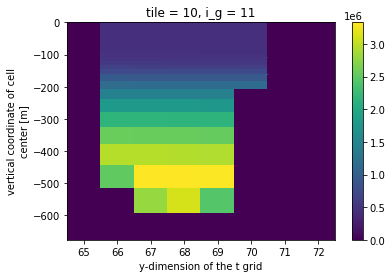

In [9]:
dyA_DaS[10,65:73,11,:].T.swap_dims({'k':'Z'})[:25].plot()

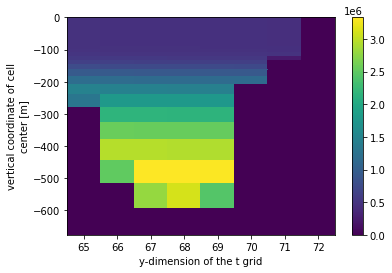

In [10]:
dyA_DaS.sum(dim=['i_g','tile'])[65:73,:25].T.swap_dims({'k':'Z'}).plot()

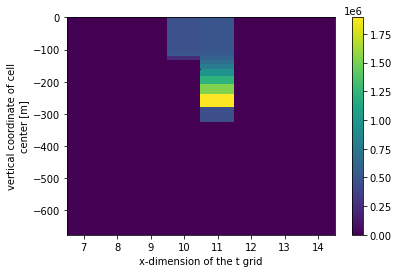

In [11]:
dxA_DaS.sum(dim=['j_g','tile'])[7:15,:25].T.swap_dims({'k':'Z'})[:25].plot()

In [12]:
sec_area_x = dyA_DaS.sum(dim=['i_g','j','tile'])
sec_area_y = dxA_DaS.sum(dim=['i','j_g','tile'])

In [13]:
# Section area (m^2)
sec_area = (sec_area_x + sec_area_y).sum('k').compute()

print('Area across the strait:',np.round(sec_area.values/1e6),'km^2')

Area across the strait: 151.0 km^2


### Volume flux

In [14]:
#u_transport = main['UVELMASS'] * main['drF'] * main['dyG']
#v_transport = main['VVELMASS'] * main['drF'] * main['dxG']

u_transport = (main['UVELMASS'] + main['UVELSTAR']) * main['drF'] * main['dyG']
v_transport = (main['VVELMASS'] + main['VVELSTAR']) * main['drF'] * main['dxG']

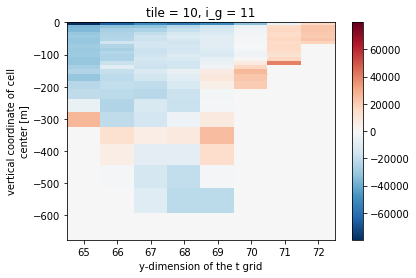

In [15]:
((u_transport[:,:,10,65:73,11]*-1).mean('time')[:25]).swap_dims({'k':'Z'}).plot()

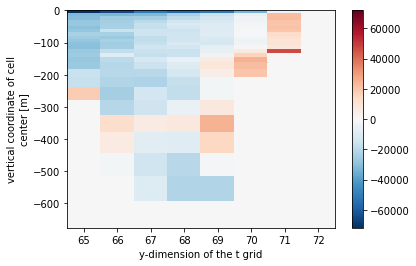

In [16]:
(u_transport * maskW).sum(dim=['i_g','tile']).mean('time')[:25,65:73].swap_dims({'k':'Z'}).plot()

In [17]:
# Volume transports
sec_trsp_x = (u_transport * maskW).sum(dim=['i_g','j','tile'])
sec_trsp_y = (v_transport * maskS).sum(dim=['i','j_g','tile'])

In [18]:
sec_trsp = (sec_trsp_x + sec_trsp_y).sum('k').compute()*Sv
#sec_trsp = sec_trsp.sel(time=slice('1993-01-01','2015-12-31'))

print('Vol. flux (1992-2015):', 
      np.round(sec_trsp.mean('time').values,1),'±',np.round(2*sec_trsp.std('time').values,1),'Sv')

Vol. flux (1992-2015): -1.6 ± 0.6 Sv


Vol. flux (1993-2015): -1.5 ± 0.6 Sv


### Calculate freshwater fluxes

In [19]:
# Reference salinity
Sref = 34.8
#Sref = 35.0

In [20]:
grid = ecco.get_llc_grid(main)

In [21]:
SALT_at_u = grid.interp(main.SALT, 'X', boundary='extend')
SALT_at_v = grid.interp(main.SALT, 'Y', boundary='extend')

In [22]:
# Freshwater advective (Eulerian) fluxes (m^3/s)
ADVx_FW = (main.UVELMASS+main.UVELSTAR)*main.dyG*main.drF*(Sref-SALT_at_u)/Sref
ADVy_FW = (main.VVELMASS+main.VVELSTAR)*main.dxG*main.drF*(Sref-SALT_at_v)/Sref

In [23]:
# Freshwater transports
sec_trsp_x = (ADVx_FW * maskW).sum(dim=['i_g','j','tile'])
sec_trsp_y = (ADVy_FW * maskS).sum(dim=['i','j_g','tile'])

In [24]:
# Freshwater transport (Sv)
sec_FWtrsp = (sec_trsp_x + sec_trsp_y).sum('k').compute()*Sv
#sec_FWtrsp = sec_FWtrsp.sel(time=slice('1993-01-01','2015-12-31'))
print('FW flux (Sref =',Sref, '/ 1992-2015):', 
      np.round(sec_FWtrsp.mean('time').values*1e3,1),'±',np.round(2*sec_FWtrsp.std('time').values*1e3,1),'mSv')

FW flux (Sref = 34.8 / 1992-2015): -86.9 ± 31.0 mSv


FW flux (Sref = 35.0 / 1992-2015): -95.3 ± 33.0 mSv


### Sea ice flux

In [26]:
Sref = 35.0
#Sref = 34.8
Sice = 4.0
rho_w = 1003
rho_ice = 900

ice_to_fw = (1-Sice/Sref)*(rho_ice/rho_w)

In [27]:
# Sea ice freshwater fluxes (m^3/s)
SIu_transport = main['SIuheff'] * main['dyG'] * ice_to_fw
SIv_transport = main['SIvheff'] * main['dxG'] * ice_to_fw

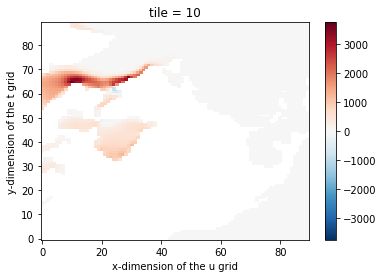

In [28]:
SIu_transport.mean('time')[10].where(main.hFacW[0,10].values==1).plot()

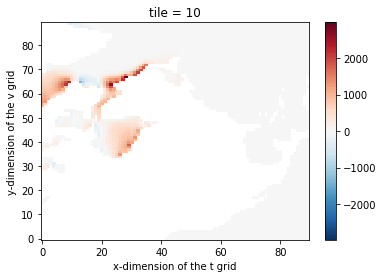

In [29]:
SIv_transport.mean('time')[10].where(main.hFacS[0,10].values==1).plot()

In [30]:
# Sea ice freshwater fluxes through strait (m^3/s)
sec_trsp_x = (SIu_transport * maskW).sum(dim=['i_g','j','tile'])
sec_trsp_y = (SIv_transport * maskS).sum(dim=['i','j_g','tile'])

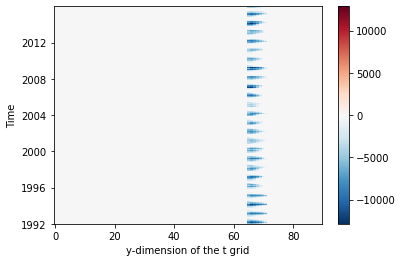

In [31]:
(SIu_transport * maskW).sum(dim=['i_g','tile']).plot()

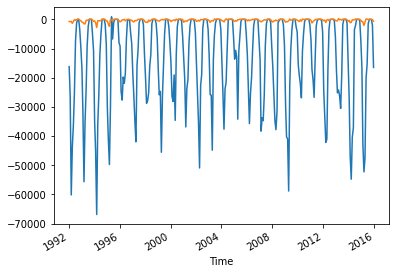

In [32]:
sec_trsp_x.plot()
sec_trsp_y.plot()

In [33]:
# Sea ice freshwater transport (Sv)
sec_SItrsp = (sec_trsp_x + sec_trsp_y).compute()*Sv

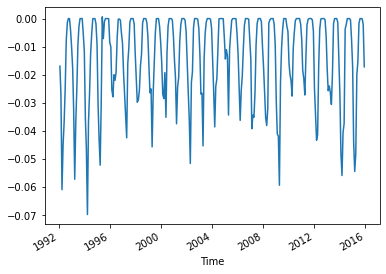

In [34]:
sec_SItrsp.plot()

In [35]:
print('Sea ice FW flux (Sref =',Sref, '/ Sice =',Sice,'/ 1992-2015):', 
      np.round(sec_SItrsp.mean('time').values*1e3,1),'±',np.round(2*sec_SItrsp.std('time').values*1e3,1),'mSv')

Sea ice FW flux (Sref = 35.0 / Sice = 4.0 / 1992-2015): -13.8 ± 30.8 mSv


### Compare volume, freshwater and sea ice flux through Fram Strait

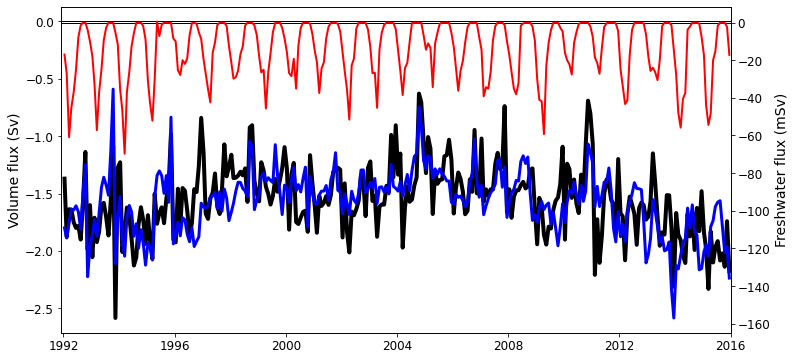

In [39]:
fig, ax1 = plt.subplots(figsize=(12,6))

ax1.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax1.plot(sec_trsp.time, sec_trsp, lw=4, color='k',label='Volume')
ax1.set_xlim([datetime.date(1991, 12, 1), datetime.date(2016, 1, 1)])
#ax1.set_ylim([-6.5e4,6.5e4])
ax1.tick_params(axis='both',labelsize=12)
ax1.set_ylabel('Volume flux (Sv)', color='k',fontsize=14)

ax2 = ax1.twinx()
ax2.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax2.plot(sec_FWtrsp.time, sec_FWtrsp*1e3, lw=3, color='blue',linestyle='-',label='Liquid')
ax2.plot(sec_SItrsp.time, sec_SItrsp*1e3, lw=2, color='r',linestyle='-',label='Sea ice')
ax2.set_xlim([datetime.date(1991, 12, 1), datetime.date(2016, 1, 1)])
#ax2.set_ylim([-1200,1200])
ax2.tick_params(axis='both',labelsize=12)
ax2.set_ylabel(r'Freshwater flux (mSv)', color='k', fontsize=14)

plt.show()

In [40]:
df = sec_trsp.reset_coords(drop=True).to_dataframe(name='vol')
df['liquid'] = sec_FWtrsp.reset_coords(drop=True).to_dataframe(name='liquid')
df['sea_ice'] = sec_SItrsp.reset_coords(drop=True).to_dataframe(name='sea_ice')

In [41]:
df.corr()

,vol,liquid,sea_ice
vol,1.000000,0.660920,0.310017
liquid,0.660920,1.000000,0.279981
sea_ice,0.310017,0.279981,1.000000


In [42]:
# Annual means
df_1yr = df.resample('1A',kind='timestamp',loffset='-6M').mean()

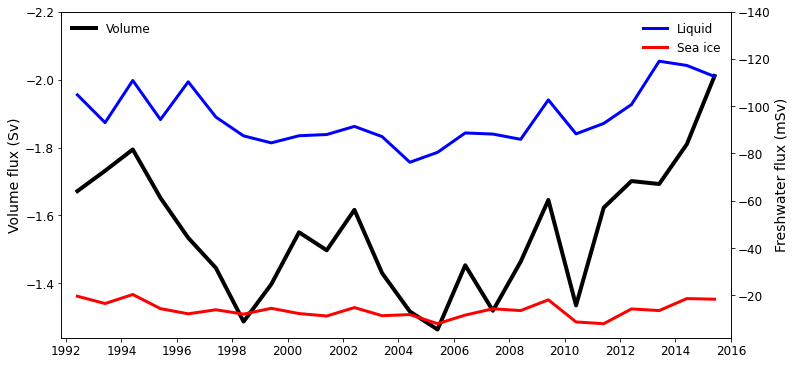

In [54]:
fig, ax1 = plt.subplots(figsize=(12,6))

ax1.plot(df_1yr.index, df_1yr.vol, lw=4, color='k',label='Volume')
ax1.set_xlim([datetime.date(1991, 12, 1), datetime.date(2016, 2, 1)])
ax1.set_xticks(pd.date_range('1992-01-01','2018-01-01',freq='24M'))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

ax1.set_ylim([-2.2,-1.24])
ax1.tick_params(axis='both',labelsize=12)
ax1.set_ylabel('Volume flux (Sv)', color='k',fontsize=14)
ax1.invert_yaxis()
ax1.legend(loc='upper left',frameon=False,fontsize=12)

ax2 = ax1.twinx()
ax2.plot(df_1yr.index, df_1yr.liquid*1e3, lw=3, color='blue',linestyle='-',label='Liquid')
ax2.plot(df_1yr.index, df_1yr.sea_ice*1e3, lw=3, color='r',linestyle='-',label='Sea ice')
ax2.set_xlim([datetime.date(1991, 12, 1), datetime.date(2016, 2, 1)])
ax2.set_xticks(pd.date_range('1992-01-01','2018-01-01',freq='24M'))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

ax2.set_ylim([-140,-2])
ax2.tick_params(axis='both',labelsize=12)
ax2.set_ylabel(r'Freshwater flux (mSv)', color='k', fontsize=14)
ax2.invert_yaxis()
ax2.legend(loc='upper right',frameon=False,fontsize=12)

plt.savefig('/mnt/efs/figure.png')
plt.savefig('/mnt/efs/figure.eps')
plt.savefig('/mnt/efs/figure.pdf')
plt.show()

In [48]:
df_1yr.corr()

,vol,liquid,sea_ice
vol,1.000000,0.789757,0.692818
liquid,0.789757,1.000000,0.622161
sea_ice,0.692818,0.622161,1.000000


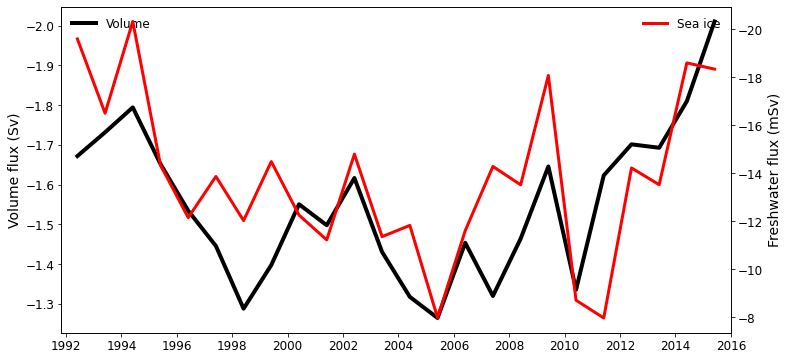

In [53]:
fig, ax1 = plt.subplots(figsize=(12,6))

ax1.plot(df_1yr.index, df_1yr.vol, lw=4, color='k',label='Volume')
ax1.set_xlim([datetime.date(1991, 12, 1), datetime.date(2016, 2, 1)])
ax1.set_xticks(pd.date_range('1992-01-01','2018-01-01',freq='24M'))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

ax1.tick_params(axis='both',labelsize=12)
ax1.set_ylabel('Volume flux (Sv)', color='k',fontsize=14)
ax1.invert_yaxis()
ax1.legend(loc='upper left',frameon=False,fontsize=12)

ax2 = ax1.twinx()
#ax2.plot(df_1yr.index, df_1yr.liquid*1e3, lw=3, color='blue',linestyle='-',label='Liquid')
ax2.plot(df_1yr.index, df_1yr.sea_ice*1e3, lw=3, color='r',linestyle='-',label='Sea ice')
ax2.set_xlim([datetime.date(1991, 12, 1), datetime.date(2016, 2, 1)])
ax2.set_xticks(pd.date_range('1992-01-01','2018-01-01',freq='24M'))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax2.tick_params(axis='both',labelsize=12)
ax2.set_ylabel(r'Freshwater flux (mSv)', color='k', fontsize=14)
ax2.invert_yaxis()
ax2.legend(loc='upper right',frameon=False,fontsize=12)

#plt.savefig('/mnt/efs/figure.png')
#plt.savefig('/mnt/efs/figure.eps')
#plt.savefig('/mnt/efs/figure.pdf')
plt.show()

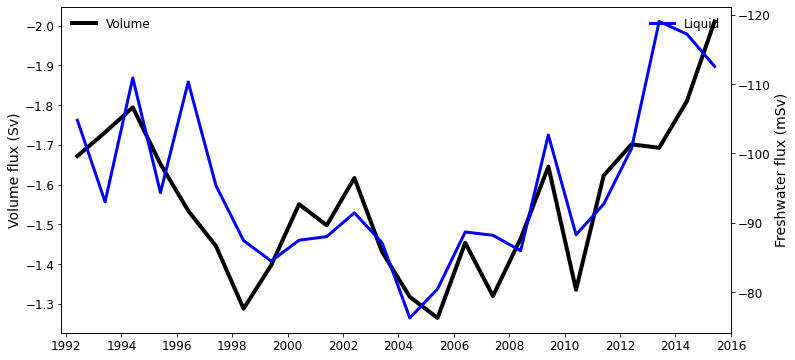

In [59]:
df_1yr

,vol,liquid,sea_ice
time,,,
1992-06-30,-1.671844,-0.104787,-0.019593
1993-06-30,-1.731599,-0.093027,-0.016499
1994-06-30,-1.794251,-0.110882,-0.020322
1995-06-30,-1.651858,-0.094338,-0.014340
1996-06-30,-1.534233,-0.110310,-0.012149
1997-06-30,-1.445513,-0.095388,-0.013864
1998-06-30,-1.287754,-0.087427,-0.012026
1999-06-30,-1.397534,-0.084481,-0.014484
2000-06-30,-1.550506,-0.087484,-0.012253


In [55]:
Vtrsp_anom = sec_trsp.groupby('time.month') - sec_trsp.groupby('time.month').mean('time')
FWtrsp_anom = sec_FWtrsp.groupby('time.month') - sec_FWtrsp.groupby('time.month').mean('time')
SItrsp_anom = sec_SItrsp.groupby('time.month') - sec_SItrsp.groupby('time.month').mean('time')

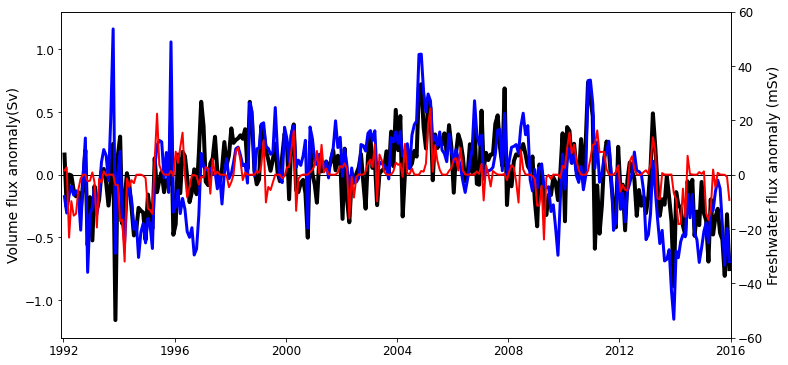

In [58]:
fig, ax1 = plt.subplots(figsize=(12,6))

ax1.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax1.plot(Vtrsp_anom.time, Vtrsp_anom, lw=4, color='k',label='Volume')
ax1.set_xlim([datetime.date(1991, 12, 1), datetime.date(2016, 1, 1)])
ax1.set_ylim([-1.3,1.3])
ax1.tick_params(axis='both',labelsize=12)
ax1.set_ylabel('Volume flux anomaly(Sv)', color='k',fontsize=14)

ax2 = ax1.twinx()
ax2.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax2.plot(FWtrsp_anom.time, FWtrsp_anom*1e3, lw=3, color='blue',linestyle='-',label='Liquid')
ax2.plot(SItrsp_anom.time, SItrsp_anom*1e3, lw=2, color='r',linestyle='-',label='Sea ice')
ax2.set_xlim([datetime.date(1991, 12, 1), datetime.date(2016, 1, 1)])
ax2.set_ylim([-60,60])
ax2.tick_params(axis='both',labelsize=12)
ax2.set_ylabel(r'Freshwater flux anomaly (mSv)', color='k', fontsize=14)

plt.show()

### Compare sea ice flux through Fram Strait with sea ice flux within Nordic Seas

In [60]:
oceFW = xr.open_dataset('/mnt/efs/data/ecco/ecco_budg_fw_oceFW.nc')

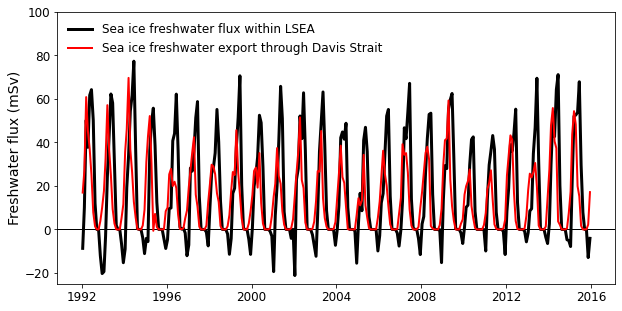

In [62]:
fig, ax = plt.subplots(figsize=(10,5))
ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(oceFW.time, oceFW.sel(region='lsea',term='forcFwSI').fw*1e3, lw=3, color='black',
        label='Sea ice freshwater flux within LSEA')
ax.plot(sec_SItrsp.time, -sec_SItrsp*1e3, lw=2, color='r',linestyle='-',
        label='Sea ice freshwater export through Davis Strait')
ax.set_ylim([-25,100])
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
ax.set_ylabel('Freshwater flux (mSv)',fontsize=14)
ax.legend(loc='upper left',frameon=False,fontsize=12)

plt.show()

#### Flux anomalies

In [64]:
oceFW_anom = oceFW.groupby('time.month') - oceFW.groupby('time.month').mean('time')
SItrsp_anom = sec_SItrsp.groupby('time.month') - sec_SItrsp.groupby('time.month').mean('time')

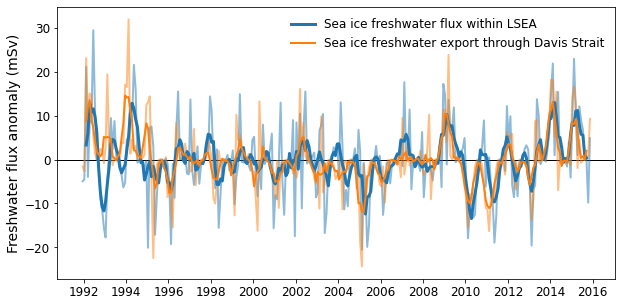

In [67]:
fig, ax = plt.subplots(figsize=(10,5))
ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(oceFW_anom.time, oceFW_anom.sel(region='lsea',term='forcFwSI').fw*1e3, lw=2,alpha=0.5,label=None)
ax.plot(SItrsp_anom.time, -SItrsp_anom*1e3, lw=2,linestyle='-',alpha=0.5,label=None)
ax.plot(oceFW_anom.time, oceFW_anom.sel(region='lsea',term='forcFwSI').fw.rolling(time=5, center=True).mean()*1e3, 
        lw=3,color='tab:blue',label='Sea ice freshwater flux within LSEA')
ax.plot(SItrsp_anom.time, -SItrsp_anom.rolling(time=5, center=True).mean()*1e3, lw=2,linestyle='-',color='tab:orange',
        label='Sea ice freshwater export through Davis Strait')


#ax.set_ylim([-25,200])
ax.set_xticks(pd.date_range('1992-01-01','2018-01-01',freq='24M'))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
ax.set_ylabel('Freshwater flux anomaly (mSv)',fontsize=14)
ax.legend(loc='upper right',frameon=False,fontsize=12)

#plt.savefig('/mnt/efs/figure.png')
#plt.savefig('/mnt/efs/figure.eps')
#plt.savefig('/mnt/efs/figure.pdf')
plt.show()

In [68]:
df = oceFW_anom.sel(region='lsea',term='forcFwSI').fw.reset_coords(drop=True).to_dataframe(name='SI_flux')
df['DaS_export'] = -SItrsp_anom.reset_coords(drop=True).to_dataframe(name='DaS_export')

In [69]:
df.corr()

,SI_flux,DaS_export
SI_flux,1.000000,0.406008
DaS_export,0.406008,1.000000


In [70]:
import seaborn as sns

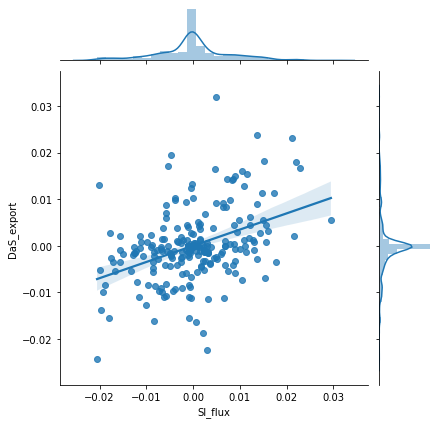

In [71]:
sns.jointplot(x="SI_flux", y="DaS_export", data=df, kind="reg")

In [72]:
# Annual means
df_1yr = df.resample('1A',kind='timestamp',loffset='-6M').mean()

In [76]:
df_1yr

,SI_flux,DaS_export
time,,
1992-06-30,0.003761,0.005780
1993-06-30,-0.002090,0.002685
1994-06-30,0.004991,0.006508
1995-06-30,-0.002517,0.000526
1996-06-30,-0.001149,-0.001664
1997-06-30,0.000038,0.000050
1998-06-30,-0.000431,-0.001788
1999-06-30,-0.000331,0.000671
2000-06-30,0.000460,-0.001561


In [74]:
from scipy import stats

In [77]:
stats.pearsonr(df_1yr.SI_flux,df_1yr.DaS_export)

(0.884124391729692, 1.0103520529832222e-08)

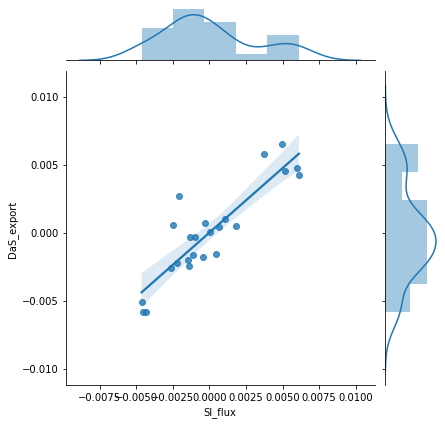

In [78]:
sns.jointplot(x="SI_flux", y="DaS_export", data=df_1yr, kind="reg")

In [79]:
oceFW_int = (oceFW_anom.isel(time=slice(1, -1)).fw*main.isel(time=slice(1, -1)).dt).cumsum(dim='time')
SItrsp_int = (SItrsp_anom.isel(time=slice(1, -1))*main.isel(time=slice(1, -1)).dt).cumsum(dim='time')


oceFW_int_anom = oceFW_int - oceFW_int.mean('time')
SItrsp_int_anom = SItrsp_int - SItrsp_int.mean('time')

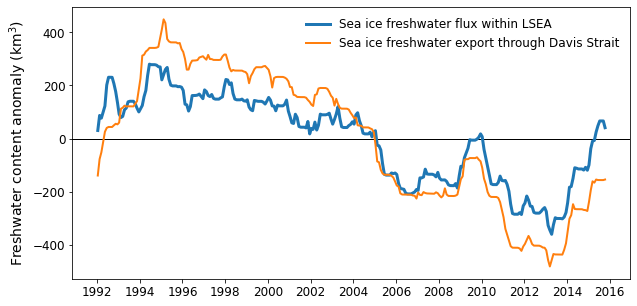

In [80]:
fig, ax = plt.subplots(figsize=(10,5))
ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(oceFW_int_anom.time, oceFW_int_anom.sel(region='lsea',term='forcFwSI')*1e-3, lw=3,
        label='Sea ice freshwater flux within LSEA')
ax.plot(SItrsp_int_anom.time, -SItrsp_int_anom*1e-3, lw=2, linestyle='-',
        label='Sea ice freshwater export through Davis Strait')
#ax.set_ylim([-25,200])
ax.set_xticks(pd.date_range('1992-01-01','2018-01-01',freq='24M'))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
ax.set_ylabel('Freshwater content anomaly (km$^3$)',fontsize=14)
ax.legend(loc='upper right',frameon=False,fontsize=12)

plt.show()